# Water Analysis
--

In [1]:
#importing the various dependencies 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import urllib.request
import seaborn as sns

import time
from scipy.stats import linregress

In [2]:
#importing the data set from csv
ar_data_import = "../CA_Water_Analysis/Ar-Water-Lab-Data.csv"
#reading the csv with pandas
ar_data = pd.read_csv(ar_data_import)
#viewing the data frame 
ar_data.head()

,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,status,county_name,sample_code,sample_date,sample_depth,sample_depth_units,parameter,result,reporting_limit,units,method_name
0,25391,09S13E20E001S,09S13E20E001S,09S13E20E001S,Groundwater,33.3798,115.6387,Review Status Unknown,Imperial,WDIS_0005418,5/11/37 9:00,NaN,Feet,Dissolved Arsenic,20.0,0.001,ug/L,UnkH Arsenic
1,15167,03S28E31H090M,03S28E31H090M,03S28E31H090M,Groundwater,37.6466,118.9217,Review Status Unknown,Mono,WDIS_0316416,9/17/41 0:00,NaN,Feet,Total Arsenic,1460.0,0.001,ug/L,UnkH Arsenic
2,15167,03S28E31H090M,03S28E31H090M,03S28E31H090M,Groundwater,37.6466,118.9217,Review Status Unknown,Mono,WDIS_0316417,7/1/42 0:00,NaN,Feet,Total Arsenic,2560.0,0.001,ug/L,UnkH Arsenic
3,46753,18S37E34A001SM,18S37E34A001SM,18S37E34A001SM,Groundwater,36.3291,117.9472,Review Status Unknown,Inyo,WDIS_0005267,11/17/45 0:00,NaN,Feet,Total Arsenic,0.0,0.001,ug/L,UnkH Arsenic
4,31500,14S20E10M001M,14S20E10M001M,14S20E10M001M,Groundwater,36.7286,119.7868,Review Status Unknown,Fresno,WDIS_0001797,5/2/47 0:00,NaN,Feet,Dissolved Arsenic,0.0,0.001,ug/L,UnkH Arsenic


In [3]:
#converting the 'sample_date' column into usable format

#first, we need to iterrate through the rows of date to /
# add "19" and "20" to 20th and 21st century year values, respectively
#it's a nightmare...

for idx, row in ar_data.iterrows(): 
    year=row['sample_date'].split(' ')[0].split('/')[-1]
    if int(year)>22: 
        date=row['sample_date'].split(' ')[0]
        time=row['sample_date'].split(' ')[-1]
        new_date=date.split('/')[:-1]
        new_date=new_date+[f'19{year}']
        # print('/'.join(new_date))
        new_date_str='/'.join(new_date)
    else: 
        date=row['sample_date'].split(' ')[0]
        time=row['sample_date'].split(' ')[-1]
        new_date=date.split('/')[:-1]
        new_date=new_date+[f'20{year}']
        # print('/'.join(new_date))
        new_date_str='/'.join(new_date)
    ar_data.loc[idx, 'sample_date']=new_date_str+' '+time

In [4]:
# convert the cleaned date formatting into "datetime" that Pandas recognizes
ar_data['sample_date'] = pd.to_datetime(ar_data['sample_date'])
# sort the data frame by earliest date at top
ar_data = ar_data.sort_values(by='sample_date')
ar_data.head()

,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,status,county_name,sample_code,sample_date,sample_depth,sample_depth_units,parameter,result,reporting_limit,units,method_name
0,25391,09S13E20E001S,09S13E20E001S,09S13E20E001S,Groundwater,33.3798,115.6387,Review Status Unknown,Imperial,WDIS_0005418,1937-05-11 09:00:00,NaN,Feet,Dissolved Arsenic,20.0,0.001,ug/L,UnkH Arsenic
1,15167,03S28E31H090M,03S28E31H090M,03S28E31H090M,Groundwater,37.6466,118.9217,Review Status Unknown,Mono,WDIS_0316416,1941-09-17 00:00:00,NaN,Feet,Total Arsenic,1460.0,0.001,ug/L,UnkH Arsenic
2,15167,03S28E31H090M,03S28E31H090M,03S28E31H090M,Groundwater,37.6466,118.9217,Review Status Unknown,Mono,WDIS_0316417,1942-07-01 00:00:00,NaN,Feet,Total Arsenic,2560.0,0.001,ug/L,UnkH Arsenic
3,46753,18S37E34A001SM,18S37E34A001SM,18S37E34A001SM,Groundwater,36.3291,117.9472,Review Status Unknown,Inyo,WDIS_0005267,1945-11-17 00:00:00,NaN,Feet,Total Arsenic,0.0,0.001,ug/L,UnkH Arsenic
4,31500,14S20E10M001M,14S20E10M001M,14S20E10M001M,Groundwater,36.7286,119.7868,Review Status Unknown,Fresno,WDIS_0001797,1947-05-02 00:00:00,NaN,Feet,Dissolved Arsenic,0.0,0.001,ug/L,UnkH Arsenic


In [5]:
#sort by the total amount of arsenic found
ar_data_date = ar_data.sort_values(['sample_date'], ascending=False)
#view the sorted data frame with oldest data at top
ar_data_date.head()

,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,status,county_name,sample_code,sample_date,sample_depth,sample_depth_units,parameter,result,reporting_limit,units,method_name
45984,45916,C3A - Hood,Sacramento River @ Hood - C3A,B9D82211312,Surface Water,38.367700,121.520500,Review Status Unknown,Sacramento,C1222B0898,2022-12-08 11:00:00,1.0,Meters,Dissolved Arsenic,1.90,1.0,ug/L,EPA 200.8 (D)
45983,45914,C10A,C10A - San Joaquin River near Vernalis @ SJR Club,B9D74081159,Surface Water,37.679340,121.264700,Review Status Unknown,San Joaquin,C1222B0891,2022-12-06 11:00:00,1.0,Meters,Dissolved Arsenic,1.34,1.0,ug/L,EPA 200.8 (D)
45982,47221,Devil Cyn AB2,Devil Canyon 2nd Afterbay,KA041323,Surface Water,34.203111,117.340306,Review Status Unknown,San Bernardino,S1122B0418,2022-11-16 11:35:00,0.3,Meters,Total Arsenic,4.69,1.0,ug/L,EPA 200.8 (T)
45981,47221,Devil Cyn AB2,Devil Canyon 2nd Afterbay,KA041323,Surface Water,34.203111,117.340306,Review Status Unknown,San Bernardino,S1122B0418,2022-11-16 11:35:00,0.3,Meters,Dissolved Arsenic,5.26,1.0,ug/L,EPA 200.8 (D)
45980,357,Check 66,CALIFORNIA AQU A INL TO MOJAVE SI,KA040341,Surface Water,34.336000,117.303600,Review Status Unknown,San Bernardino,S1122B0417,2022-11-16 10:20:00,0.3,Meters,Total Arsenic,4.76,1.0,ug/L,EPA 200.8 (T)


In [6]:
#sort by the total amount of arsenic found 
ar_data_result = ar_data.sort_values(['result'], ascending=False)
#create a new dataframe from top 100 highest 'offending' stations
top_offender_df = ar_data_result.head(100)
#sort the top_offender_df by 'station_type', thus having 'Surface Water' stations listed at the top
sorted_top_offender_df = top_offender_df.sort_values(['station_type'], ascending=False)
#viewing the top offender data frame
sorted_top_offender_df.head()

,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,status,county_name,sample_code,sample_date,sample_depth,sample_depth_units,parameter,result,reporting_limit,units,method_name
18567,206,TWITCHELL01,Twitchell Island Sample 01,B9V80621369,Surface Water,38.1052,121.6173,Review Status Unknown,Sacramento,C1091A0836,1991-10-18 09:00:00,1.0,Meters,Dissolved Arsenic,5880000.0,0.001,ug/L,Std Method 3114 C
4336,5359,LEVIATHAN MINE A MO,LEVIATHAN MINE A MO (PIT),G8308639,Surface Water,38.7046,119.6577,Review Status Unknown,Alpine,WDIS_0332072,1969-05-08 09:30:00,NaN,Feet,Dissolved Arsenic,58000.0,0.001,ug/L,"Std Method 3500-As, C"
1125,5099,MIDDLE ALKALI LK NR,MIDDLE ALKALI LK NR CEDARVILLE-2L,G1L13210070,Surface Water,41.5349,120.1172,Review Status Unknown,Modoc,WDIS_0010806,1958-12-02 10:00:00,NaN,Feet,Dissolved Arsenic,1800.0,0.001,ug/L,Std Method 11th Ed. Arsenic
13124,1605,BALAKLALA MINE DR 3,BALAKLALA MINE DR 3,A2014900,Surface Water,40.7249,122.4975,Review Status Unknown,Shasta,WDIS_0006252,1982-12-28 11:30:00,NaN,Feet,Total Arsenic,1100.0,0.001,ug/L,"Std Method 3500-As, C"
30339,702,Semi Tropic 3 Pumpin,Semi Tropic 3 arsenic monitoring,KA020699,Surface Water,35.9833,119.9833,Review Status Unknown,Kern,SJA0907B1020,2007-09-18 09:10:00,1.0,Meters,Total Dissolved Solids,375000.0,1.000,ug/L,Std Method 2540 C


In [7]:
#count number of uniquie instances each county name appears for each column
county_df = ar_data_date.groupby(['county_name']).count()
#sort the data frame alphabetically by county name
sorted_county_df = county_df.sort_values(['county_name'], ascending=True)
#show data frame
sorted_county_df.head()

,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,status,sample_code,sample_date,sample_depth,sample_depth_units,parameter,result,reporting_limit,units,method_name
county_name,,,,,,,,,,,,,,,,,
Alameda,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1525,1657,1657,1657,1657,1657,1657
Alpine,46,46,46,46,46,46,46,46,46,46,0,46,46,46,46,46,46
Amador,45,45,45,45,45,45,45,45,45,45,37,45,45,45,45,45,45
Butte,3971,3971,3971,3971,3971,3971,3971,3971,3971,3971,3486,3971,3971,3937,3971,3971,3971
Calaveras,70,70,70,70,70,70,70,70,70,70,11,70,70,70,70,70,70


In [8]:
# station_num = sorted_ar_df['station_id'].unique().size
# station_thing = sorted_ar_df.groupby(['station_id']).count()
# sorted_station_thing = station_thing.sort_values(['station_name'], ascending=False)
# sorted_station_thing

NameError: name 'sorted_ar_df' is not defined

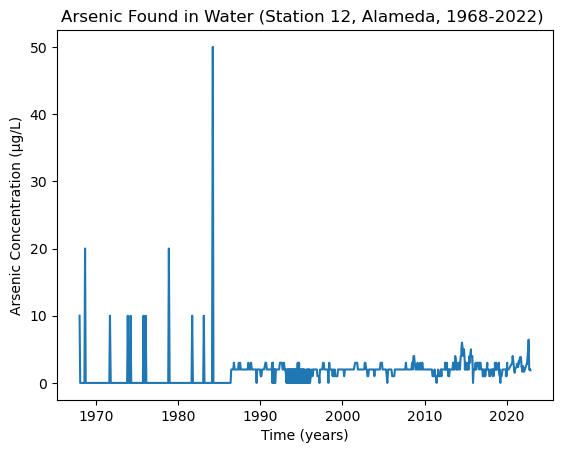

In [12]:
#create a data frame containing only station #12
station_12_df = ar_data_date[(ar_data_date["station_id"]==12)]
#plotting the station 12 data frame as a line graph
plt.plot(station_12_df['sample_date'], station_12_df['result'])
plt.xlabel("Time (years)")
plt.ylabel("Arsenic Concentration (µg/L)")
plt.title("Arsenic Found in Water (Station 12, Alameda, 1968-2022) ")

plt.show()

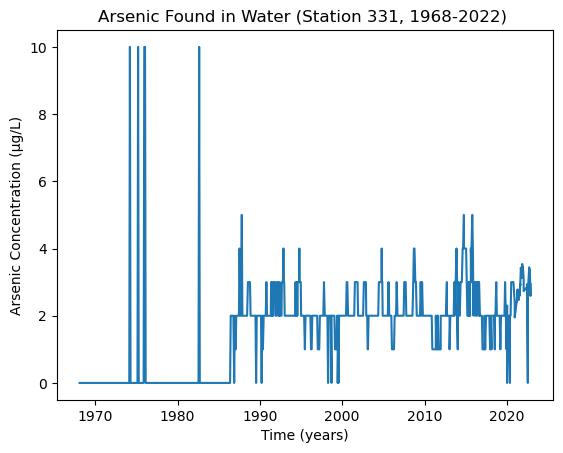

In [13]:
#create a data frame containing only station #331
station_331_df = ar_data_date[(ar_data_date["station_id"]==331)]
#plotting the station 331 data frame as a line graph
plt.plot(station_331_df['sample_date'], station_331_df['result'])
plt.xlabel("Time (years)")
plt.ylabel("Arsenic Concentration (µg/L)")
plt.title("Arsenic Found in Water (Station 331, 1968-2022) ")

plt.show()

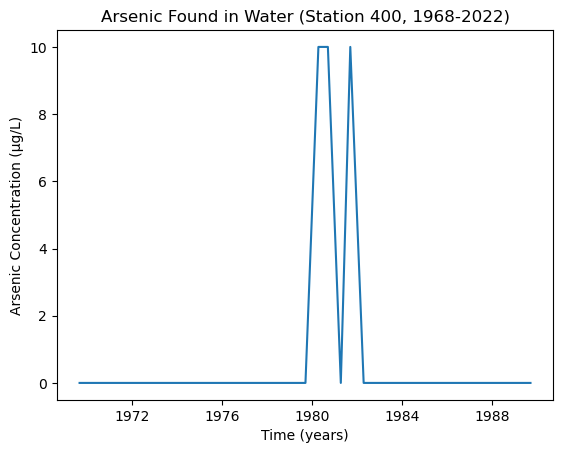

In [20]:
#create a data frame containing only station #400
station_400_df = ar_data_date[(ar_data_date["station_id"]==400)]
#plotting the station 400 data frame as a line graph
plt.plot(station_400_df['sample_date'], station_400_df['result'])
plt.xlabel("Time (years)")
plt.ylabel("Arsenic Concentration (µg/L)")
plt.title("Arsenic Found in Water (Station 400, 1968-2022)")

plt.show()

In [38]:
import seaborn as sns

In [39]:
county_df=ar_data.loc[(ar_data["county_name"] == "Kern") |
                              (ar_data["county_name"] == "Tehama") |
                              (ar_data["county_name"] == "Glen") |
                              (ar_data["county_name"] == "Shasta") |
                              (ar_data["county_name"] == "Modoc") |
                              (ar_data["county_name"] == "Los Angeles") |
                              (ar_data["county_name"] == "Alameda") |
                              (ar_data["county_name"] == "San Bernardino")]

#create a data frame containing pre 1990 data
early_county_df = county_df[(county_df["sample_date"]<='1990-01-01')]

#create a data frame containing post 1990 data
late_county_df = county_df[(county_df["sample_date"]>='1990-01-01')]

#create pre 1990 Tehama and post 1990 Tehama dfs
early_Tehama = early_county_df[(county_df["county_name"]=='Tehama')]
early_Tehama_mean = early_Tehama.groupby("sample_date").mean()["result"]
early_Tehama_raw_mean_df = pd.DataFrame({"Tehama_pre_90": early_Tehama_mean})
#create post 1990 Tehama and post 1990 Tehama dfs
late_Tehama = late_county_df[(county_df["county_name"]=='Tehama')]
late_Tehama_mean = late_Tehama.groupby("sample_date").mean()["result"]
late_Tehama_raw_mean_df = pd.DataFrame({"Tehama_post_90": late_Tehama_mean})


# plot boxplots of pre and post 1990 Tehama values
ax = sns.boxplot(x='sample_date', y='Tehama_pre_90', data=late_Tehama_raw_mean_df, color='#99c2a2')
#ax = sns.swarmplot(x="treatments", y="value", data=df_melt, color='#7d0013')
plt.show()



# plotting early_Tehama_mean as a line graph
# plt.plot(early_Tehama_mean_df['sample_date'], station_400_df['result'])
# plt.xlabel("Time (years)")
# plt.ylabel("Arsenic Concentration (µg/L)")
# plt.title("Arsenic Found in Water (Station 400, 1968-2022)")

# plt.show()county_df

/Users/adampaganini/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/adampaganini/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ValueError: Could not interpret input 'sample_date'